# K-Nearest Neighbors (kNN)

## References

https://www.kaggle.com/datasets/uciml/glass

## Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

## Global Variables

In [2]:
# random state 
random_state = 4781
# random_state = 7644

# colors
c_scale = 256
c1 = (1, 1, 1) # grey
c2 = (1, 0, 0) # red
c3 = (181/c_scale, 204/c_scale, 6/c_scale) # yellow
c4 = (6/c_scale, 122/c_scale, 204/c_scale) # blue
c5 = (0, 0, 0) # black

## Import Dataset

In [3]:
# Source: https://www.kaggle.com/datasets/uciml/glass

# Dataset Column Overview: 
# ------------------------------------------------------------------------------

# X01: Id number: 1 to 214
# X02: RI: refractive index
# X03: Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)
# X04: Mg: Magnesium
# X05: Al: Aluminum
# X06: Si: Silicon
# X07: K: Potassium
# X08: Ca: Calcium
# X09: Ba: Barium
# X10: Fe: Iron
#   y: Type of glass: (class attribute):
#   ------------------------------------
#      1: building_windows_float_processed
#      2: building_windows_non_float_processed
#      3: vehicle_windows_float_processed
#      4: vehicle_windows_non_float_processed
#      5: containers
#      6: tableware
#      7: headlamps

In [4]:
# load dataset from github
filepath1 = 'https://raw.githubusercontent.com/notfakearcher/julian/main/02_data/glass.csv'
df0 = pd.read_csv(filepath1, header = 0)
df0.head()

,ID,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [5]:
# identify X_cols and y_col
all_cols = df0.columns.values.copy()
y_col = 'Type'
cond1 = all_cols != y_col
X_cols = all_cols[cond1]

In [6]:
# standardize column names
df1 = df0.copy()
zeros = len(X_cols[-1])
new_all_cols = all_cols
temp = (np.arange(0, len(X_cols)) + 1).astype('str')

new_y_col = 'y'
new_X_cols = ['X' + i.zfill(zeros) for i in temp]

new_all_cols[cond1] = new_X_cols
new_all_cols[~cond1] = new_y_col

df1.columns = new_all_cols

df1.head()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [7]:
# check data structure
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     214 non-null    int64  
 1   X02     214 non-null    float64
 2   X03     214 non-null    float64
 3   X04     214 non-null    float64
 4   X05     214 non-null    float64
 5   X06     214 non-null    float64
 6   X07     214 non-null    float64
 7   X08     214 non-null    float64
 8   X09     214 non-null    float64
 9   X10     214 non-null    float64
 10  y       214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [8]:
# describe data
df1.describe()

,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,107.500000,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,61.920648,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.000000,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,54.250000,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,107.500000,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,160.750000,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,214.000000,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [9]:
# check missing values
df1.isna().sum()

X01    0
X02    0
X03    0
X04    0
X05    0
X06    0
X07    0
X08    0
X09    0
X10    0
y      0
dtype: int64

## Data Cleaning

In [10]:
# remove usless columns
X_exclude = ['X01']
df1 = df1.drop(columns = X_exclude, errors = 'ignore')
df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## Transform Dataset

In [11]:
# response column
y_col = new_y_col
y_col

'y'

In [12]:
# predictor columns
cond1 = df1.columns != y_col
X_cols = df1.columns[cond1]
X_cols

Index(['X02', 'X03', 'X04', 'X05', 'X06', 'X07', 'X08', 'X09', 'X10'], dtype='object')

In [13]:
# get unique y_labels
y_labels = [
  'building_windows_float_processed', 
  'building_windows_non_float_processed', 
  'vehicle_windows_float_processed', 
  'vehicle_windows_non_float_processed', 
  'containers', 
  'tableware', 
  'headlamps'
]
y_labels = {y_labels[i]: i for i in range(len(y_labels))}
# y_labels = {i:y_labels[i] for i in range(len(y_labels))}
y_labels

{'building_windows_float_processed': 0,
 'building_windows_non_float_processed': 1,
 'vehicle_windows_float_processed': 2,
 'vehicle_windows_non_float_processed': 3,
 'containers': 4,
 'tableware': 5,
 'headlamps': 6}

In [14]:
# rename y_labels
df1.y = df1.y.replace(y_labels)
df1.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [15]:
# normalize all X_cols
df2 = df1.copy()
norm = StandardScaler()
# norm = MinMaxScaler()
# norm = RobustScaler()
df2[X_cols] = norm.fit_transform(df2[X_cols])

df2.head()

,X02,X03,X04,X05,X06,X07,X08,X09,X10,y
0,0.872868,0.284953,1.254639,-0.692442,-1.127082,-0.671705,-0.145766,-0.352877,-0.586451,1
1,-0.249333,0.591817,0.636168,-0.170460,0.102319,-0.026213,-0.793734,-0.352877,-0.586451,1
2,-0.721318,0.149933,0.601422,0.190912,0.438787,-0.164533,-0.828949,-0.352877,-0.586451,1
3,-0.232831,-0.242853,0.698710,-0.310994,-0.052974,0.112107,-0.519052,-0.352877,-0.586451,1
4,-0.312045,-0.169205,0.650066,-0.411375,0.555256,0.081369,-0.624699,-0.352877,-0.586451,1


In [16]:
# melt df2 into a dataframe where cols become stacked as rows
df3 = df2.melt(
  id_vars = y_col,
  value_vars = X_cols,
  var_name = 'X',
  value_name = "X_value"
)
df3.head()

,y,X,X_value
0,1,X02,0.872868
1,1,X02,-0.249333
2,1,X02,-0.721318
3,1,X02,-0.232831
4,1,X02,-0.312045


## Visualize Dataset

In [17]:
# figure setup
fig_cols = 3
fig_rows = np.ceil(len(X_cols)/fig_cols).astype('int')
y_max = np.round(df2[X_cols].max().max(), 0)
y_min = np.round(df2[X_cols].min().min(), 0)
n_levels = df2.y.unique().size
palette1 = [c1 for i in range(n_levels)]
palette2 = [c3, c4]
figsize = (20, 30)

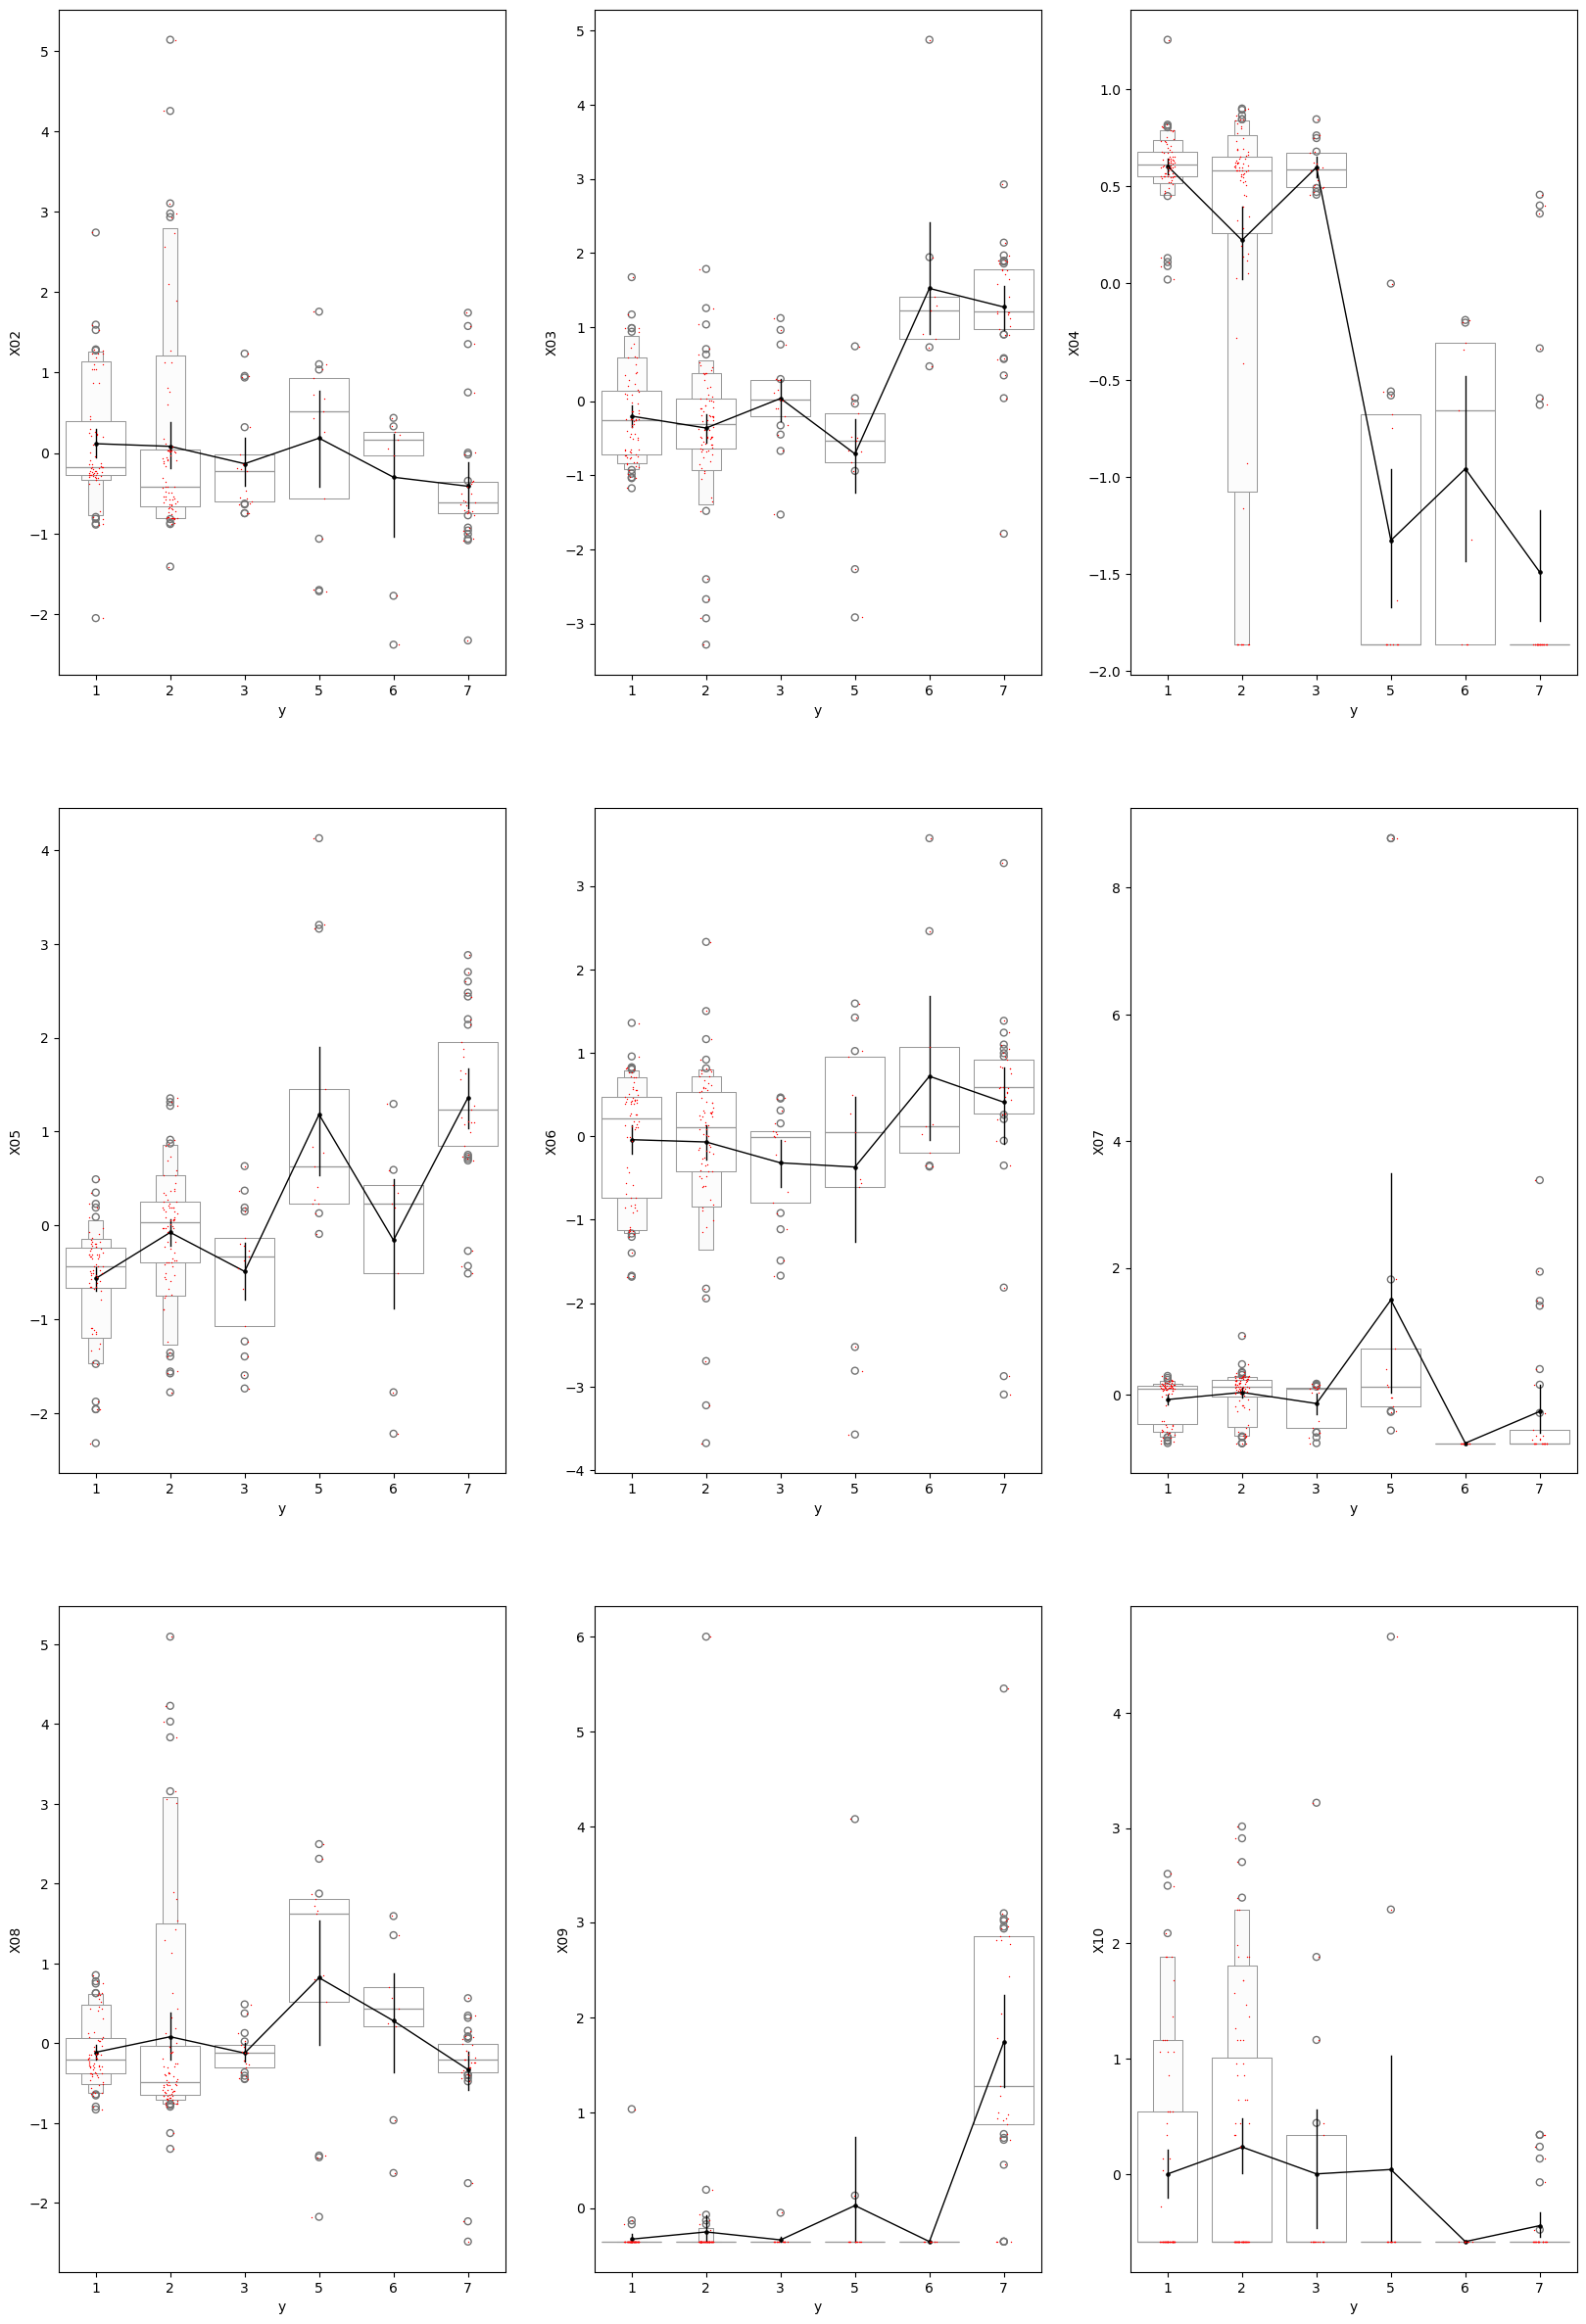

In [18]:
# subplot of y vs each X (stripplot + violinplot + boxenplot)
f1, axes = plt.subplots(fig_rows, fig_cols, figsize = figsize)
itr = 0
for x in X_cols:
  row = np.floor(itr/fig_cols) 
  row = row.astype('int')
  col = np.mod(itr, fig_cols)
  col = col.astype('int') 
  # print(row)
  # print(col)
  # p1 = sns.violinplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p2 = sns.boxenplot(ax = axes[row, col], data = df2, x = y_col, y = x, hue = y_col, palette = palette1)
  p3 = sns.stripplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c2, size = 1)
  p4 = sns.pointplot(ax = axes[row, col], data = df2, x = y_col, y = x, color = c5, linewidth = 1)
  axes[row, col].legend_ = None
  # axes[row, col].set_ylim(y_min, y_max)
  itr = itr + 1

## Feature Selection

### Select Features Using Model Selection Methods

In [19]:
# seperate data into X and y
X = df2[X_cols]
y = np.ravel(df2[y_col])

In [20]:
# estimator model
estimator_model = RandomForestClassifier(
  n_estimators = 50,
  max_depth = 100,
  criterion = 'gini',
  random_state = random_state
)    

In [21]:
# fit estimmator model
temp = estimator_model.fit(X, y)

In [22]:
# feature importance values
feature_importance = estimator_model.feature_importances_
feature_importance

array([0.15453203, 0.10534526, 0.175085  , 0.14474709, 0.08796823,
       0.06292624, 0.12091508, 0.10482489, 0.04365617])

In [23]:
# threshold feature importance
feature_importance_threshold = np.mean(feature_importance)
# feature_importance_threshold = np.median(feature_importance)
# feature_importance_threshold = np.quantile(feature_importance, q = 0.5)
feature_importance_threshold

0.1111111111111111

In [24]:
# initialize SelectFromModel
myfit = SelectFromModel(
  estimator = estimator_model,
  threshold = feature_importance_threshold
)

In [25]:
# fit SelectFromModel
temp = myfit.fit_transform(X, y)

In [26]:
# get columns kept from ensemble - random forest feature selection
X_cols_rf = myfit.get_feature_names_out()
X_cols_rf

array(['X02', 'X04', 'X05', 'X08'], dtype=object)

## Train and Test ML Model

In [27]:
# X_cols to include after feature selection
# X_include = X.columns
X_include = X_cols_rf
print(len(X_include))
print(X_include)

4
['X02' 'X04' 'X05' 'X08']


In [28]:
# split data into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X[X_include], y, 
  # stratify = y, shuffle = True,
  train_size = 0.7, random_state = random_state
)

In [29]:
# initialize k-Nearest Neighbor model
myfit = KNeighborsClassifier(
  n_neighbors = 3,
  # metric = "chebyshev",
  # metric = "cityblock",
  # metric = "cosine",
  # metric = "euclidean",
  algorithm = 'auto'
)

In [30]:
# fit model
temp = myfit.fit(X_train, y_train)

In [31]:
# get predictions on test data
y_hat = myfit.predict(X_test)

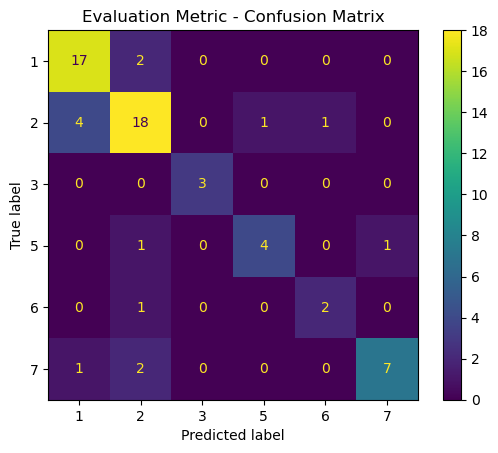

In [32]:
# model evaluation - confusion matrix

# get confusion matrix
cm = confusion_matrix(
  y_true = y_test,
  y_pred = y_hat
)

# show confusion matrix visual
labels = myfit.classes_
p1 = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
p1.plot()
plt.title('Evaluation Metric - Confusion Matrix')
plt.show()

In [33]:
# model evaluation - recall, precision , F1-score
metric_report = classification_report(y_true = y_test, y_pred = y_hat, output_dict = False, zero_division = 0) 
print(metric_report)

              precision    recall  f1-score   support

           1       0.77      0.89      0.83        19
           2       0.75      0.75      0.75        24
           3       1.00      1.00      1.00         3
           5       0.80      0.67      0.73         6
           6       0.67      0.67      0.67         3
           7       0.88      0.70      0.78        10

    accuracy                           0.78        65
   macro avg       0.81      0.78      0.79        65
weighted avg       0.79      0.78      0.78        65

